In [1]:
import heapq
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from random import uniform
from random import choice
from pylab import *
import networkx as nx
import math

In [2]:
class London:
    '''
    This class is used to initialize the network that consists of
    neighborhoods (nodes) and roads between them (edges). It also 
    stores some important attributes such as timer, speed of ambulances 
    and strategy. Parameters include:
    
    run_until - time until which the simulation needs to run (minute)
    n_amb - the number of ambulances available to the entire city
    strategy - ‘uniform_strategy’, ‘adjusted_strategy’ or ‘proportional_strategy’. 
      ‘uniform_strategy’ - the ambulances are equally distributed among stations. 
      'proportional_strategy’ - we are adjusting the number of ambulances proportionally to the 
    emergency probability in a corresponding neighborhood. 
      ‘adjusted strategy’ - we are allocating more cars to the neighborhoods 
    that have the longest response times in the uniform strategy.

    '''
    def __init__(self, run_until, n_amb, strategy):
        
        #time until which the simulation will be running
        self.run_until = run_until
        #the number of available ambulances in the city
        self.n_amb = n_amb
        #emergency queue
        self.emergencies = []
            
        #counting the number of people who died
        #in this simulation, if a person waits more than 60 minutes
        #the emergency is taken out from the queue and the person dies
        self.death_count = 0
        #the timer of the simulation
        #at each iteration, we will increment timer by 1 minute
        self.timer = 0
        
        self.emergencies_count = []
        #speed of an ambulance
        self.speed = 0.3
        #selected strategy
        self.strategy = strategy
        #Graph object
        self.G = nx.Graph()

        #adding nodes and edges with their relevant attributes
        self.G.add_nodes_from([
            (1, {"name": "Marylebone", "emerg_prob": 0.28}),
            (2, {"name": "Fitzrovia", "emerg_prob": 0.22}),
            (3, {"name": "Soho", "emerg_prob": 0.28}),
            (4, {"name": "Mayfair", "emerg_prob": 0.32}),
            (5, {"name": "Nottinghill", "emerg_prob": 0.15}),
            (6, {"name": "Bayswater", "emerg_prob": 0.28}),
            (7, {"name": "Hyde Park", "emerg_prob": 0.28}),
            (8, {"name": "Knights Bridge", "emerg_prob": 0.28}),
            (9, {"name": "Belgravia", "emerg_prob": 0.28}),
            (10, {"name": "Pimlico", "emerg_prob": 0.28}),
            (11, {"name": "Regent's Park", "emerg_prob": 0.28}),
            (12, {"name": "Westminster", "emerg_prob": 0.36}),
            (13, {"name": "Bloomsbury", "emerg_prob": 0.28}),
            (14, {"name": "Covent Garden", "emerg_prob": 0.28}),
            (15, {"name": "Lambeth", "emerg_prob": 0.38}),
            (16, {"name": "South Bank", "emerg_prob": 0.33}),
            (17, {"name": "Holborn", "emerg_prob": 0.28}),
            (18, {"name": "Clerkenwell", "emerg_prob": 0.28}),
            (19, {"name": "Barbican", "emerg_prob": 0.28}),
            (20, {"name": "The City", "emerg_prob": 0.1}),
            (21, {"name": "Spitalfields", "emerg_prob": 0.28}),
            (22, {"name": "London Bridge", "emerg_prob": 0.28}),
            (23, {"name": "St. James", "emerg_prob": 0.28}),
        ])
        #distances between different nodes in miles
        self.G.add_edges_from([
            (1, 2, {"distance": 1.3}), (1, 3, {"distance": 1.2}), (1, 4, {"distance": 0.7}),
            (1, 6, {"distance": 2.3}),(1, 11, {"distance": 0.6}),(2, 3, {"distance": 0.8}),
            (2, 13, {"distance": 1.2}),(2, 14, {"distance": 0.4}),(2, 11, {"distance": 2.1}),
            (3, 4, {"distance": 0.6}),(3, 23, {"distance": 1.2}),(3, 13, {"distance": 1.3}),
            (3, 14, {"distance": 1.3}),(4, 7, {"distance": 0.7}),(4, 9, {"distance": 1.5}),
            (4, 23, {"distance": 0.9}),(5, 6, {"distance": 0.9}),(6, 7, {"distance": 1.4}),
            (7, 8, {"distance": 1.8}),(7, 9, {"distance": 1.5}),(7, 23, {"distance": 1.9}),
            (8, 9, {"distance": 1.0}),(9, 10, {"distance": 0.8}),(9, 12, {"distance": 1.1}),
            (9, 23, {"distance": 1.4}),(10, 12, {"distance": 1.2}),(10, 23, {"distance": 2.1}),
            (12, 23, {"distance": 1.0}),(12, 14, {"distance": 1.4}),(12, 15, {"distance": 1.3}),
            (13, 14, {"distance": 1.3}),(13, 17, {"distance": 1.1}),(13, 18, {"distance": 1.3}),
            (13, 19, {"distance": 2.3}),(13, 20, {"distance": 3.3}),(14, 23, {"distance": 0.4}),
            (14, 17, {"distance": 1.2}),(14, 16, {"distance": 1.8}),(15, 16, {"distance": 1.6}),
            (16, 17, {"distance": 2.3}),(16, 20, {"distance": 1.9}),(16, 22, {"distance": 1.5}),
            (17, 19, {"distance": 2.2}),(17, 20, {"distance": 3.0}),(18, 19, {"distance": 1.0}),
            (18, 21, {"distance": 1.9}),(19, 20, {"distance": 1.4}),(19, 21, {"distance": 1.9}),
            (19, 21, {"distance": 1.9}),(20, 21, {"distance": 3.3}),
        ])

        #changing the mapping so we could refer to nodes by their names
        self.mapping = {1: "Marylebone", 2: "Fitzrovia", 3: "Soho", 
                        4:"Mayfair", 5:"Nottinghill", 6:"Bayswater",
                        7:"Hyde Park", 8:"Knights Bridge",9:"Belgravia",
                        10:"Pimlico",11:"Regent's Park",12:"Westminster",
                        13:"Bloomsbury",14:"Covent Garden",15:"Lambeth",
                        16:"South Bank",17:"Holborn",18:"Clerkenwell",
                        19:"Barbican",20:"The City",21:"Spitalfields",
                        22:"London Bridge",23:"St. James"}
        self.G = nx.relabel_nodes(self.G, self.mapping)

        #setting positions of the nodes according to the map
        self.pos = {"Marylebone": (25, 30),"Fitzrovia": (30, 30),"Soho": (28, 26), 
                    "Mayfair": (25, 25), "St. James": (30, 20),"Nottinghill":(18, 30),
                    "Bayswater":(20, 28),"Hyde Park":(21, 25),"Knights Bridge":(17, 23),
                    "Belgravia":(19, 20),"Pimlico":(20, 18),"Regent's Park":(25, 35),
                    "Westminster":(26, 19),"Bloomsbury":(34, 33), "Covent Garden":(33, 27),
                    "Lambeth":(28, 18),"South Bank":(29, 23),"Holborn":(37, 27),
                    "Clerkenwell":(39, 31),"Barbican":(38, 29),"The City":(33, 22), 
                    "Spitalfields":(42, 29),"London Bridge":(33, 25),"St. James":(25, 23) 
                   } 
            #drawiing the nodes with their positions and colors
        
        #creating a dictionry of stations
        self.stations_list = {}
        #amd  a dictionary of free ambulances
        self.free_ambulances = {}
        for i in range(len(list(self.G.nodes))):
            #initializing the dictionaries
            self.stations_list[list(self.G.nodes)[i]] = Station(self.strategy[i])
            self.free_ambulances[list(self.G.nodes)[i]] = [self.strategy[i]]

        #a dictionary to store response times for each neighbourhood
        self.response_times={}
        for i in list(self.G.nodes):
            self.response_times[i]=[]

        #visualizing the network - uncomment if network visualization is needed
        #nx.draw(self.G, self.pos)
        #setting labels for each node a little higher than the nodes' positions
        #for i in self.G.nodes:
            #x,y=self.pos[i]
            #plt.text(x,y+1,s=i, bbox=dict(facecolor='red', alpha=0.5),horizontalalignment='center')
        #plt.show()
        
    #finds the closest station
    def find_station(self, emerg):
        #adds all stations with available ambulances to a dictionary
        #creates a dictionary of stations
        avail = {}
        for i in list(self.G.nodes):
            avail[i] = []
        #counter to check how many stations have at least 1 ambulance
        count=0
        for i in self.stations_list:
            #if there is at least one ambulance
            if self.stations_list[i].number_of_ambulances > 0:
                #increment the counter
                count+=1
                #calculate the number of free ambulances
                n=self.stations_list[i].number_of_ambulances
                avail[i].append(nx.shortest_path_length(self.G, source=i, target=emerg, weight="distance"))
        
        #if at least one station has an ambulance
        if count>0:
            #eliminating the keys with empty items
            avail = dict( [(k,v) for k,v in avail.items() if len(v)>0])
            #finding the closest station
            station = min(avail, key=avail.get)
            #geting the distance to the chosen station
            dist = avail[station][0]
            #adjusting the number of available stations
            self.stations_list[station].number_of_ambulances -= 1
            #calculating time needed to get back and forth + random noise
            time = 2*dist/self.speed + np.random.normal(25,5)
            
            return station, time
        
        else:
            #if no available ambulances, then we just continue
            pass
        
    #the function in which we will run the simulation
    def run_simulation(self):
        #storing times which ambulances have to return back
        #so we could adjust the number of free ambs as appropriate
        return_times = {}
        for i in list(self.G.nodes):
            return_times[i] = []
        #run until we reached the time until when the simulation is supposed to run
        while self.timer < self.run_until:
            #update the timer at each timestep
            self.timer+=1
            self.emergencies_count.append(len(self.emergencies))
            
            #check if any ambulances need to return back to the station
            for key in return_times:
                for value in return_times[key]:
                    if value==self.timer:
                        return_times[key].remove(value)
                        self.stations_list[key].number_of_ambulances+=1
            
            #add the current number of free ambulances
            for i in self.stations_list:
                if self.free_ambulances[i][0] != 0:
                    self.free_ambulances[i].append(self.stations_list[i].number_of_ambulances/self.free_ambulances[i][0])
                else:
                    self.free_ambulances[i].append(0)
            
            #go through each node and generate an emergency there with a certain probability
            for i in self.G.nodes:
                if uniform(0,1)<self.G.nodes[i]['emerg_prob']:
                    #and add it to the priority queue
                    heapq.heappush(self.emergencies, Emergency(self.G.nodes[i]["name"], self.timer))
            
            #creating the same queue as a placeholder so we could pop until there are
            #no emergencies that have waited more than 60 minutes
            self.emergencies_ = self.emergencies
            #if there is at least one emergency
            if len(self.emergencies)>0:
                #pop while there are not emergencies that have waited longer than 60 minutes
                while self.timer-heapq.heappop(self.emergencies_).time >=60:
                    #add 60 minutes response time to the list
                    self.response_times[heapq.heappop(self.emergencies).location].append(60)
                    #increment the death count
                    self.death_count+=1
            
            #solve emergencies
            for i in range(len(self.emergencies)):
                #get an emergency from the list
                emerg = heapq.heappop(self.emergencies)
                #find the closest station
                looking = self.find_station(emerg.location)
                
                #get location of the station
                #get the time it will take to solve the emergency
                if looking is not None:
                    return_times[looking[0]].append(self.timer+math.ceil(looking[1]))
                    self.response_times[emerg.location].append(self.timer-emerg.time)
                else:
                    #if there are no ambulances, continue the simuulation
                    break
                
        return self.response_times, self.death_count, self.free_ambulances, self.G, self.pos, self.emergencies_count
    
class Emergency:
    '''
    A class to store and handle emergencies
    This way it is easier to keep track of location and time
    the emergency happened
    '''
    
    def __init__(self, location, time):
        self.location = location
        self.time = time
        
    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        #so the emergency with the earliest time was chosen
        return self.time < other.time
        
class Station:
    '''
    A small class that handles station objects. It helps us
    know how many ambulances are available in each station
    '''
    def __init__(self, number_of_ambulances):
        self.number_of_ambulances = number_of_ambulances

        


In [3]:
#this function distributes a number proportionally to a variable
#for example if we have 100 cars and a list [0.2, 0.3, 0.5] this will
#return [20, 30, 50]
def distribute2(available, weights):
     distributed_amounts = []
     total_weights = sum(weights)
     for weight in weights:
         weight = float(weight)
         p = weight / total_weights
         distributed_amount = round(p * available)
         distributed_amounts.append(distributed_amount)
         total_weights -= weight
         available -= distributed_amount
     return distributed_amounts

In [4]:
#number of ambulances
n=200
#setting up the fractions according to which we will
#distribute the ambulances
uniform_probabilities=[6.24/23 for i in range(23)]
#this one is just the emergency probabilities of for each neighbourhood
proportional_probabilities=[0.28,0.22,0.28,0.32,0.15,0.28,0.28,0.28,0.28,0.28,0.28,0.36,0.28,0.28,0.28,0.33,0.28,0.28,0.28,0.1,0.28,0.28,0.28]
adjusted_probabilities=[2.5,2,1.75,1.5,1.25,1,0.5,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28]

#creating lists that are distributions of ambulances according to three
#different strategies
proportional_strategy = distribute2(n, proportional_probabilities)
uniform_strategy = distribute2(n, uniform_probabilities)
adjusted_strategy = distribute2(n, adjusted_probabilities)

#creating an instance of a city and testing the algorithm
city=London(600, n, uniform_strategy)
response_times, death_count, free_ambulances, graph, pos, emergencies_count = city.run_simulation()
    

In [5]:
print('The average shortest path is:', 
      nx.average_shortest_path_length(graph, weight='distance'))
      
      

The average shortest path is: 3.3873517786561242


In [6]:
emerg_counts = []
for i in range(100):
    city=London(600, 200, uniform_strategy)
    response_times, death_count, free_ambulances, graph, pos, emergencies_count  = city.run_simulation()
    emerg_counts.append(emergencies_count)
    
    

In [ ]:
mean_counts = []
mean_err = []
x = []
for i in range(0,len(emerg_counts[0]),20):
    count=[]
    x.append(i)
    for k in range(100):
        count.append(emerg_counts[k][i])
        print(emerg_counts[k][i])
    st_err = sts.sem(count)
    mean_err.append(2*1.96*st_err)
    mean_counts.append(sum(count)/100)
    count=[]

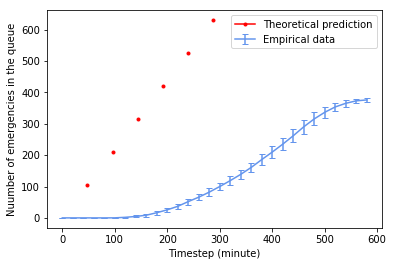

In [8]:
plt.errorbar(x,mean_counts, yerr=mean_err,color='cornflowerblue', capsize=3, label='Empirical data')
plt.plot([48], [105], marker='o', markersize=3, color="red", label='Theoretical prediction')
plt.plot([96], [210], marker='o', markersize=3, color="red")
plt.plot([144], [315], marker='o', markersize=3, color="red")
plt.plot([192], [420], marker='o', markersize=3, color="red")
plt.plot([240], [525], marker='o', markersize=3, color="red")
plt.plot([288], [630], marker='o', markersize=3, color="red")
plt.xlabel('Timestep (minute)')
plt.ylabel('Nuumber of emergencies in the queue')
plt.legend()
plt.show()

In [9]:
#proportional strategy data collection
deaths_p = []
free_amb_p =  [[] for _ in range(23)]
response_times_p = [[] for _ in range(23)]
for i in range(100):
    city=London(600, 200, proportional_strategy)
    response_times, death_count, free_ambulances, graph, pos, emergencies_count  = city.run_simulation()
    deaths_p.append(death_count)
    for l in range(23):
        #[1:] because the first number is just the number of 
        #ambulances assigned to that station
        free_amb_p[l].append(np.nanmean(list(free_ambulances.items())[l][1][1:]))
        
    for k in range(23):
        response_times_p[k].append(np.nanmean(list(response_times.items())[k][1]))
    

In [10]:
#calculating standard errors for confidence intervals
#and getting expected values
neighs = np.linspace(1,23,23)
err_resp_p=[]
err_free_p=[]
for i in range(len(response_times_p)):
    err_resp_p.append(sts.sem(2*response_times_p[i],nan_policy='omit')*1.96)
    err_free_p.append(sts.sem(2*free_amb_p[i],nan_policy='omit')*1.96)
    
for i in range(len(response_times_p)):
    response_times_p[i] = np.nanmean(response_times_p[i])
    free_amb_p[i] = np.nanmean(free_amb_p[i])

In [11]:
#uniform strategy
deaths_u = []
free_amb_u =  [[] for _ in range(23)]
response_times_u = [[] for _ in range(23)]
for i in range(100):
    city=London(600,200,uniform_strategy)
    response_times, death_count, free_ambulances, graph, pos, emergencies_count  = city.run_simulation()
    deaths_u.append(death_count)
    for l in range(23):
        free_amb_u[l].append(np.nanmean(list(free_ambulances.items())[l][1][1:]))
    
    for k in range(23):
        response_times_u[k].append(np.nanmean(list(response_times.items())[k][1]))

In [12]:
neighs = np.linspace(1,23,23)
err_resp_u=[]
err_free_u=[]

for i in range(len(response_times_u)):
    err_resp_u.append(sts.sem(2*response_times_u[i],nan_policy='omit')*1.96)
    err_free_u.append(sts.sem(2*free_amb_u[i],nan_policy='omit')*1.96)
    
for i in range(len(response_times_u)):
    response_times_u[i] = np.nanmean(response_times_u[i])
    free_amb_u[i] = np.nanmean(free_amb_u[i])


In [13]:
#adjusted strategy data collection
deaths_a = []
free_amb_a =  [[] for _ in range(23)]
response_times_a = [[] for _ in range(23)]
for i in range(100):
    city=London(600, 200, adjusted_strategy)
    response_times, death_count, free_ambulances, graph, pos, emergencies_count  = city.run_simulation()
    deaths_a.append(death_count)
    for l in range(23):
        #[1:] because the first number is just the number of 
        #ambulances assigned to that station
        free_amb_a[l].append(np.nanmean(list(free_ambulances.items())[l][1][1:]))
        
    for k in range(23):
        response_times_a[k].append(np.nanmean(list(response_times.items())[k][1]))
    

In [14]:
err_resp_a=[]
err_free_a=[]
for i in range(len(response_times_a)):
    err_resp_a.append(sts.sem(2*response_times_a[i],nan_policy='omit')*1.96)
    err_free_a.append(sts.sem(2*free_amb_a[i],nan_policy='omit')*1.96)
    
for i in range(len(response_times_a)):
    response_times_a[i] = np.nanmean(response_times_a[i])
    free_amb_a[i] = np.nanmean(free_amb_a[i])

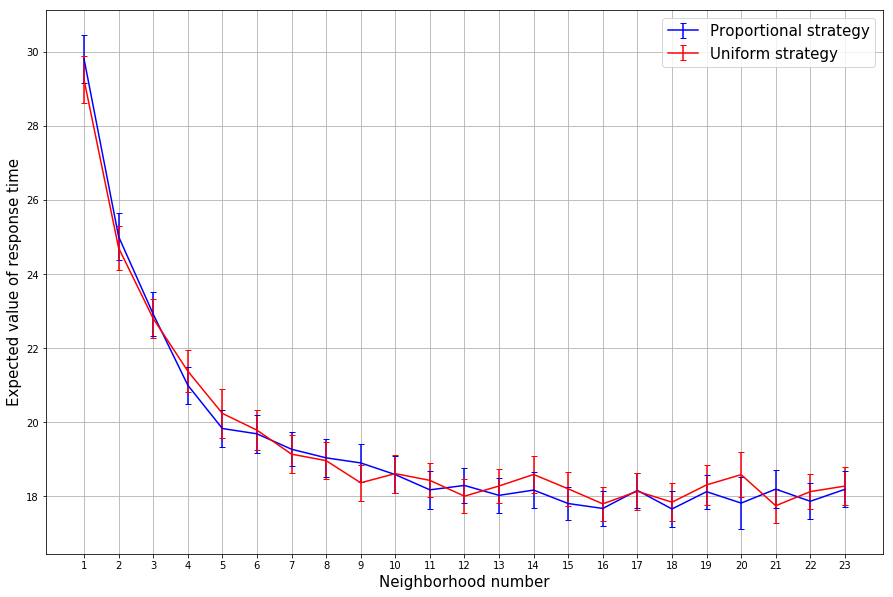

In [15]:
plt.figure(figsize=(15,10))
plt.errorbar(neighs, response_times_p, yerr=err_resp_p, capsize=3, color='blue', label='Proportional strategy')
plt.errorbar(neighs, response_times_u, yerr=err_resp_u, capsize=3, color='red', label='Uniform strategy')
plt.xticks(np.arange(1, 24, step=1))
plt.xlabel('Neighborhood number', size=15)
plt.ylabel('Expected value of response time', size=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

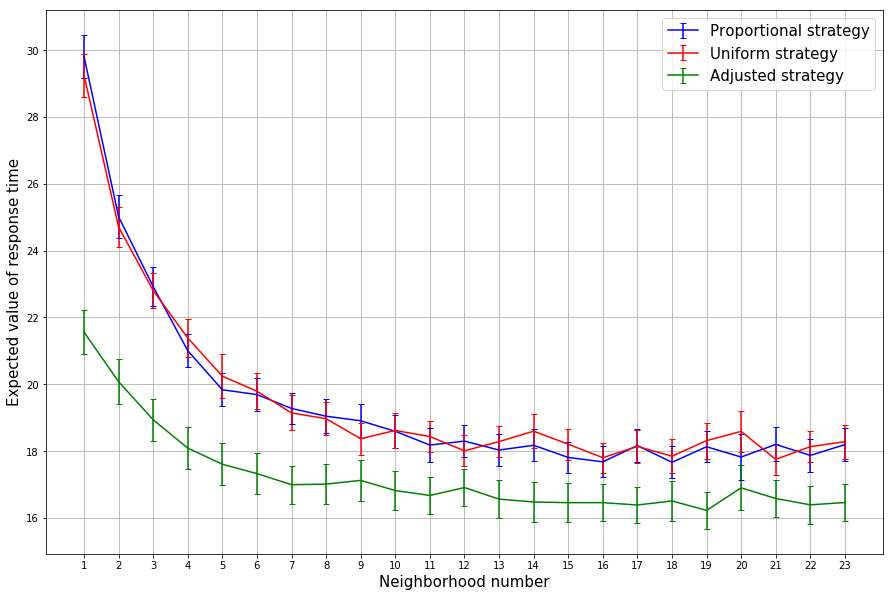

In [16]:
plt.figure(figsize=(15,10))
plt.errorbar(neighs, response_times_p, yerr=err_resp_p, capsize=3, color='blue', label='Proportional strategy')
plt.errorbar(neighs, response_times_u, yerr=err_resp_u, capsize=3, color='red', label='Uniform strategy')
plt.errorbar(neighs, response_times_a, yerr=err_resp_a, capsize=3, color='green', label='Adjusted strategy')
plt.xticks(np.arange(1, 24, step=1))
plt.xlabel('Neighborhood number', size=15)
plt.ylabel('Expected value of response time', size=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

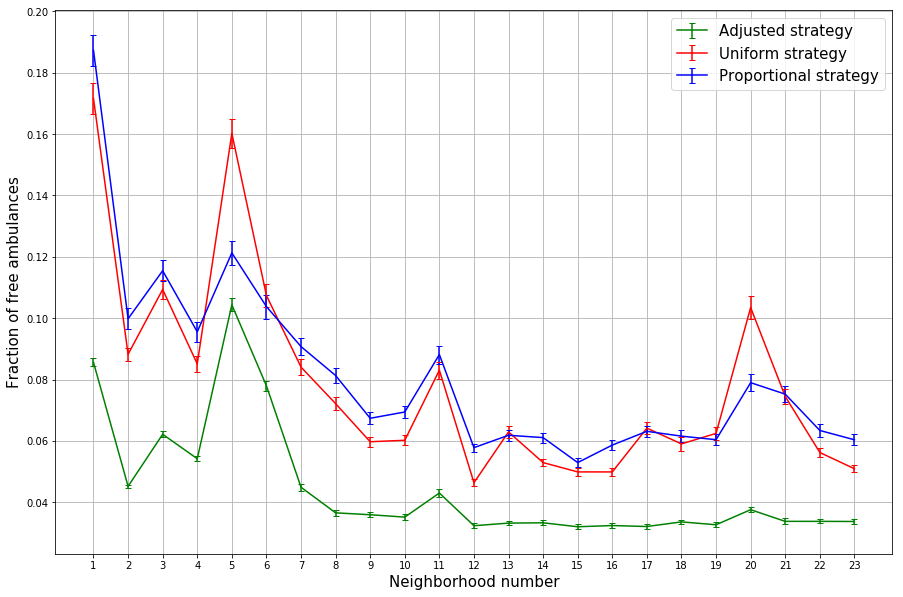

In [17]:
plt.figure(figsize=(15,10))
plt.errorbar(neighs, free_amb_a, yerr=err_free_a, capsize=3, color='green', label='Adjusted strategy')
plt.errorbar(neighs, free_amb_u, yerr=err_free_u, capsize=3, color='red', label='Uniform strategy')
plt.errorbar(neighs, free_amb_p, yerr=err_free_p, capsize=3, color='blue', label='Proportional strategy')
plt.xticks(np.arange(1, 24, step=1))
plt.xlabel('Neighborhood number', size=15)
plt.ylabel('Fraction of free ambulances', size=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

In [18]:
#This and the next cell did not run for me in the Jupyter Notebook
#Hence, I had to run these codes in google colab

#columns
strategies = [proportional_probabilities, uniform_probabilities, adjusted_probabilities]
#rows
ns = np.linspace(24,240,10)
df = np.zeros((10, 3))
for s in range(len(strategies)):
    for n in range(len(ns)):
      store = []
      for i in range(50):
        city=London(600, ns[n], distribute2(ns[n], strategies[s]))
        response_times, death_count, free_ambulances, graph, pos, emergencies_count = city.run_simulation()
        store.append(death_count)
      df[n][s]=np.mean(store)
    
import seaborn as sns
x_axis_labels = ['Proportional', 'Uniform', 'Adjusted']
y_axis_labels = np.linspace(24,240,10) 
ax = sns.heatmap(df, cmap="YlGnBu", annot=True, fmt=".2f", xticklabels=x_axis_labels, yticklabels=y_axis_labels)

ImportError: cannot import name 'remove_na'

In [ ]:
#Netowrk where the nodes are
plt.figure(figsize=(8, 6))

nx.draw(
    graph, pos=pos,
    node_color=[np.mean(response_times[i]) for i in response_times],
    cmap=plt.cm.viridis)

# Create color bar
value_map = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(np.mean(response_times[i]) for i in response_times),vmax=max(np.mean(response_times[i]) for i in response_times)))
plt.colorbar(mappable=value_map)
for i in graph.nodes:
            x,y=pos[i]
            plt.text(x,y+1,s=i, bbox=dict(facecolor='red', alpha=0.5),horizontalalignment='center')
plt.show()

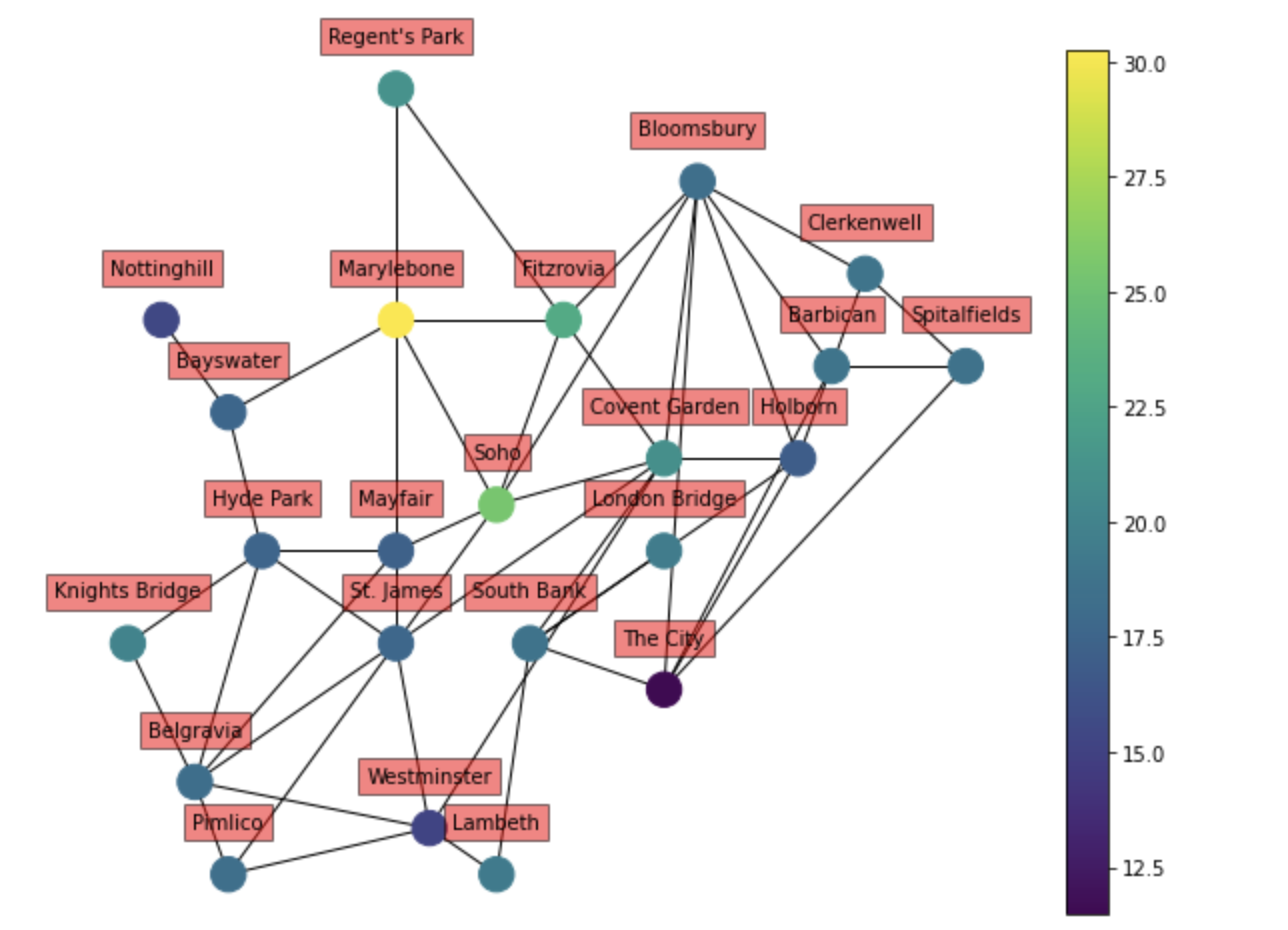

In [1092]:
Image(filename='Screen Shot 2021-04-22 at 4.54.19 PM.png')